In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import ipywidgets as w
from IPython.display import display
from IPython.display import clear_output

sns.set(palette='Set1')

### Load pre-processed detailed cycle count survey data (4 quarterly surveys, 2017-18)

In [2]:
df = pd.read_csv('data/detailed-survey-extra-cols.csv') # 15MB file
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'],format= '%H:%M:%S').dt.time

### Create additional columns

In [3]:
def float_time_mid_15(timestamp):
    mid = timestamp.hour + ((timestamp.minute + 7.5) / 60)
    return mid

def start_hour_mid(start_hour):
    mid = start_hour + 0.5
    return mid

df['Survey Time'] = df['TimeStamp'].apply(float_time_mid_15)
df['Hour Mid'] = df['Start Hour'].apply(start_hour_mid)

### Create variables and aggregation functions required for drawing graphs

In [4]:
def calc_means(df):
    hire = df['Number of cycle hire bikes'].mean()
    other = df['Number of normal cycles'].mean()
    total = df['Total cycles'].mean()
    return {'hire':hire, 
            'other':other, 
            'total':total}

means = calc_means(df)
av_hire = means['hire']
av_other = means['other']

def interval(period):
    
    intervaldict = {'Early Morning': 1,
               'AM Peak': 2,
               'Inter Peak': 3,
               'PM Peak': 4,
               'Late Evening': 5}
    if type(period) in (int,float):
        x = period
       
    else:
        x = intervaldict[period]
    return x

option_df_boolean = {
    'Weather': 'Bad Weather',
    'Day of week':'Weekend',
    'Daylight':'Dark'}

option_pair_labels = {
    'Weather': ['Bad Weather','Good Weather'],
    'Day of week':['Weekend','Weekday'],
    'Daylight':['Dark','Light']}

def filterdf(option,groupby,dfcustom=df):
    if option == 'All':
        df_option = tidyfiltered(dfcustom,groupby,'All')       
     
    else:    
        boolean = option_df_boolean[option]
        true_label = option_pair_labels[option][0]
        df_true = dfcustom[dfcustom[boolean]==True]
        df_true = tidyfiltered(df_true,groupby,true_label) 

        boolean = option_df_boolean[option]
        df_false = dfcustom[dfcustom[boolean]==False]
        
        false_label = option_pair_labels[option][1]
        df_false = tidyfiltered(df_false,groupby,false_label) 

        df_option = df_true.append(df_false)
    
    return df_option

def tidyfiltered(df, groupby, which):
         
    dfg = df.groupby(groupby).mean().reset_index()    
    dfg['hire-bike-%'] = dfg['Number of cycle hire bikes'] / dfg['Total cycles']
    dfg['Hire bikes'] = dfg['Number of cycle hire bikes'] / av_hire
    dfg['Other bikes'] = dfg['Number of normal cycles'] / av_other           
    dfg = dfg.sort_values(by='Start Hour')    

    dfgsub = dfg[[groupby,'Hire bikes','Other bikes']]
    dfgg = pd.melt(dfgsub, id_vars=[groupby])
    dfgg.columns = [groupby,'Bike type', 'Number']
    dfgg['Interval'] = dfgg[groupby].apply(interval)    
    dfgg['Selection'] = which
        
    dfgg = dfgg.sort_values(by='Interval') 
    
    return dfgg

### Function for production of graphs

In [5]:
def draw_graphs(var,groupby): 
        
    graphs = filterdf(var,groupby) 
        
    if groupby != 'Peak Period':
        graphs = graphs[[groupby,'Number','Selection','Bike type']]        
        
        if groupby == 'Survey Time':
            hours = list(range(6,22))            
            selections = list(graphs['Selection'].unique())
            bike_types = list(graphs['Bike type'].unique())
            
            #the below could be more succinct
            for s in selections:
                df_filt = graphs
                df_filt_s = df_filt[df_filt['Selection']==s]
                for bt in bike_types:                    
                    df_filt_bt = df_filt_s[df_filt_s['Bike type']==bt] 
                    for h in hours:                   
                        fhl = list(df_filt_bt[groupby])
                        fhl2 = [int(v) for v in fhl]

                        if h not in fhl2:  
                            row = [h, 0, s, bt]
                            graphs.loc[len(graphs)] = row                        
                        
                        else:                            
                            continue 
        
        g = sns.relplot(x=groupby, y='Number', col='Selection', hue='Bike type', kind='line',
                        hue_order=['Hire bikes', 'Other bikes'],
                        data=graphs, col_wrap=2)
        if groupby == 'Survey Time':
            g.set(xlim=(3,23),xticks=[4,6,8,10,12,14,16,18,20,22])
            
    else:
        g = sns.catplot(x=groupby, y='Number', col='Selection', 
                        order=['Early Morning','AM Peak','Inter Peak','PM Peak','Late Evening'],
                        hue_order=['Hire bikes', 'Other bikes'],
                        hue='Bike type', kind='bar', sharey=True, data=graphs, col_wrap=2)
        g.set_xticklabels(rotation=45)
    
    g.set(ylim=(0,3.5))

### Create interactive dropdown options for graphs

In [6]:
opts = w.Select(
    options=['All','Day of week', 'Weather', 'Daylight'],
    value='All',
    description='Selection',
    disabled=False)

timegp = w.Select(
    options=['Peak Period','Start Hour'],
    value='Peak Period',
    description='Time Grouping',
    disabled=False)

butt = w.Button(
    description='Update',
    disabled=False)

def on_update(b):
    clear_output()
    display(ctrls)
    draw_graphs(opts.value,'Peak Period')    
    draw_graphs(opts.value,'Survey Time')
    draw_graphs(opts.value,'Month')     

#### 'Peak Period' times

In [7]:
pdsmin = df.groupby('Peak Period').min().reset_index()
pdscols = ['Peak Period','TimeStamp']
pdsmin = pdsmin[pdscols]
pdsmin.columns = ['Period','Start']
pdsmin.sort_values(by='Start')

,Period,Start
1,Early Morning,06:00:00
0,AM Peak,07:00:00
2,Inter Peak,10:00:00
4,PM Peak,16:00:00
3,Late Evening,19:00:00


##### Notebook needs to be run in an interactive environment to use selection controls and view all outputs.

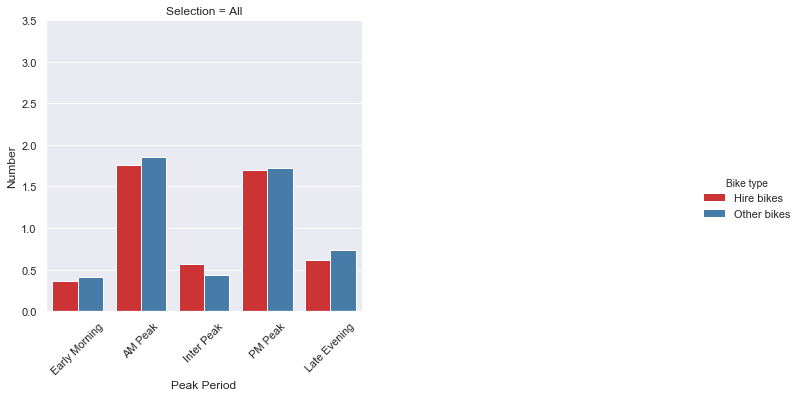

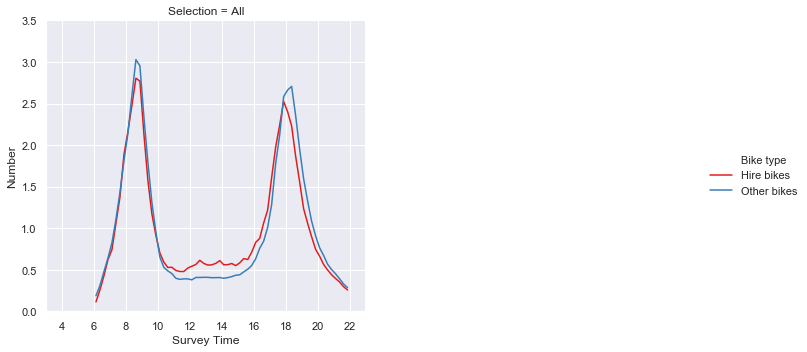

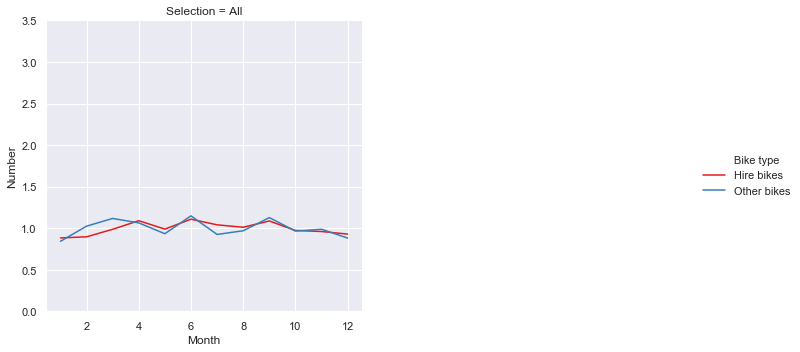

In [8]:
ctrls = w.VBox([opts,butt])
display(ctrls)
butt.on_click(on_update)



- Remarkably similar pattern of use at weekends
- Hire bikes see relatively more use between rush hours than other bikes
- Hire bike use in the evening rush hour peaks a little earlier

##### bad weather = ['cold','frost','wet','damp','sleet','snow','rain','shower','drizzle','hail']
- Relative impact on hire bikes is greater in the evening and either side of lunchtime, but not in the morning
- People on their own bikes have more incentive to use for returning home?
- Darkness and bad weather together may deter hire bike users more than other bikes, but use is still quite high
  

  
